# Análisis de Sentimientos en Tweets Políticos
## NLP para Ciencias Sociales - Clase Práctica

### Objetivos de la clase

En esta sesión nos enfocaremos exclusivamente en **análisis de sentimientos** usando:
- **pysentimiento** (modelo especializado en español para redes sociales)
- **Transformers de Hugging Face** (comparación con modelos estado del arte)
- **Análisis temporal** de evolución emocional
- **Comparación entre políticos** en dimensiones de sentimiento

**Políticos analizados:**
- Gustavo Petro
- Iván Duque  
- Álvaro Uribe
- Gustavo Bolívar

---

## 1. Configuración e instalación

In [ ]:
# Instalación de librerías necesarias
!pip install pysentimiento transformers torch plotly -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 30.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Librerías para análisis de sentimientos
from pysentimiento import create_analyzer
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Otras librerías
from collections import Counter, defaultdict
import re
from datetime import datetime
import spacy

# Configuración de visualización
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_style("whitegrid")

print("Configuración completada")
print("Librerías cargadas: pysentimiento, transformers, plotly")

Configuración completada
Librerías cargadas: pysentimiento, transformers, plotly


## 2. Carga de y preprocesamiento de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/Clases/NLP para ciencias sociales/99. Datos/tweets_muestra_estratificada.csv'
df = pd.read_csv(file_path)
print(df.head())

                         id       politico                       fecha_raw  \
0  677f1f14782ccacddc4e6e35  Gustavo Petro  Tue Mar 24 19:44:38 +0000 2020   
1  677f1f13782ccacddc4e6a20  Gustavo Petro  Thu Mar 26 13:29:14 +0000 2020   
2  677f1f15782ccacddc4e72c7  Gustavo Petro  Wed Mar 11 00:17:32 +0000 2020   
3  677f1f14782ccacddc4e6e26  Gustavo Petro  Tue Mar 24 21:19:29 +0000 2020   
4  677f1f13782ccacddc4e672d  Gustavo Petro  Fri Mar 27 12:25:47 +0000 2020   

                                               texto  \
0  Existe en nuestra sociedad burbujas informativ...   
1  La evaluación del presidente de la asociación ...   
2  Solo dejando de emitir CO2 en todo el mundo se...   
3  Solo he hablado una vez con el presidente para...   
4  El confinamiento se prolongará al menos dos me...   

                       fecha     año  mes  año_mes  
0  2020-03-24 19:44:38+00:00  2020.0  3.0  2020-03  
1  2020-03-26 13:29:14+00:00  2020.0  3.0  2020-03  
2  2020-03-11 00:17:32+00:00  2020.

In [ ]:
print(f"Dataset cargado: {len(df):,} tweets")
print(f"Período: {df['fecha'].min()} - {df['fecha'].max()}")
print(f"Políticos: {', '.join(df['politico'].unique())}")

Dataset cargado: 4,005 tweets
Período: 2019-01-01 01:30:52+00:00 - 2024-08-27 14:04:20+00:00
Políticos: Gustavo Petro, Álvaro Uribe, Iván Duque, Gustavo Bolívar


In [ ]:
# Preparar datos temporales si no existen o si la columna 'fecha' no es datetime
if 'fecha' not in df.columns:
    print("La columna 'fecha' no existe. Creando columna temporal...")
    # Create a placeholder if 'fecha' doesn't exist
    df['fecha'] = pd.date_range('2019-01-01', periods=len(df), freq='D')
else:
    # Ensure 'fecha' is datetime, coercing errors to NaT
    print("Convirtiendo la columna 'fecha' a datetime...")
    df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

# Drop rows where fecha is NaT after coercion, as they cannot be used for temporal analysis
df.dropna(subset=['fecha'], inplace=True)

# Now extract temporal components from the datetime column
df['año'] = df['fecha'].dt.year
df['mes'] = df['fecha'].dt.month
df['trimestre'] = df['fecha'].dt.quarter
df['año_trimestre'] = df['año'].astype(str) + '-Q' + df['trimestre'].astype(str)

print("Columnas temporales creadas o actualizadas.")

Convirtiendo la columna 'fecha' a datetime...
Columnas temporales creadas o actualizadas.


In [ ]:
print(df.head())

                         id       politico                       fecha_raw  \
0  677f1f14782ccacddc4e6e35  Gustavo Petro  Tue Mar 24 19:44:38 +0000 2020   
1  677f1f13782ccacddc4e6a20  Gustavo Petro  Thu Mar 26 13:29:14 +0000 2020   
2  677f1f15782ccacddc4e72c7  Gustavo Petro  Wed Mar 11 00:17:32 +0000 2020   
3  677f1f14782ccacddc4e6e26  Gustavo Petro  Tue Mar 24 21:19:29 +0000 2020   
4  677f1f13782ccacddc4e672d  Gustavo Petro  Fri Mar 27 12:25:47 +0000 2020   

                                               texto  \
0  Existe en nuestra sociedad burbujas informativ...   
1  La evaluación del presidente de la asociación ...   
2  Solo dejando de emitir CO2 en todo el mundo se...   
3  Solo he hablado una vez con el presidente para...   
4  El confinamiento se prolongará al menos dos me...   

                      fecha   año  mes  año_mes  trimestre año_trimestre  
0 2020-03-24 19:44:38+00:00  2020    3  2020-03          1       2020-Q1  
1 2020-03-26 13:29:14+00:00  2020    3  2020

In [ ]:
# Función de limpieza específica para análisis de sentimientos
def clean_text_for_sentiment(text):
    """
    Limpieza mínima para preservar contexto emocional en tweets
    """
    if pd.isna(text):
        return ""

    text = str(text)
    # Mantener emojis y signos de exclamación/interrogación para sentimientos
    # Solo quitar URLs y limpiar espacios
    text = re.sub(r'http\S+|www\.\S+|bit\.ly\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
# Aplicar limpieza
df['texto_sentiment'] = df['texto'].apply(clean_text_for_sentiment)
df = df[df['texto_sentiment'].str.len() > 10].reset_index(drop=True)

print(f"Dataset preparado: {len(df):,} tweets para análisis de sentimientos")

# Mostrar distribución por político
print(f"\nDistribución por político:")
for politico, count in df['politico'].value_counts().items():
    pct = (count / len(df)) * 100
    print(f"  {politico}: {count:,} tweets ({pct:.1f}%)")

df.head(3)

Dataset preparado: 4,000 tweets para análisis de sentimientos

Distribución por político:
  Gustavo Petro: 1,351 tweets (33.8%)
  Álvaro Uribe: 927 tweets (23.2%)
  Gustavo Bolívar: 918 tweets (22.9%)
  Iván Duque: 804 tweets (20.1%)


,id,politico,fecha_raw,texto,fecha,año,mes,año_mes,trimestre,año_trimestre,texto_sentiment
0,677f1f14782ccacddc4e6e35,Gustavo Petro,Tue Mar 24 19:44:38 +0000 2020,Existe en nuestra sociedad burbujas informativ...,2020-03-24 19:44:38+00:00,2020,3,2020-03,1,2020-Q1,Existe en nuestra sociedad burbujas informativ...
1,677f1f13782ccacddc4e6a20,Gustavo Petro,Thu Mar 26 13:29:14 +0000 2020,La evaluación del presidente de la asociación ...,2020-03-26 13:29:14+00:00,2020,3,2020-03,1,2020-Q1,La evaluación del presidente de la asociación ...
2,677f1f15782ccacddc4e72c7,Gustavo Petro,Wed Mar 11 00:17:32 +0000 2020,Solo dejando de emitir CO2 en todo el mundo se...,2020-03-11 00:17:32+00:00,2020,3,2020-03,1,2020-Q1,Solo dejando de emitir CO2 en todo el mundo se...


## 3. Análisis de sentimientos con pysentimiento

### ¿Por qué pysentimiento para tweets en español?

**pysentimiento** es una librería desarrollada específicamente para análisis de sentimientos en español, entrenada con datos de redes sociales latinoamericanas. Sus ventajas:

- **Especialización en español**: Entrenado con millones de tweets en español
- **Comprensión de jerga**: Maneja lenguaje informal y expresiones regionales
- **Contexto de redes sociales**: Optimizado para textos cortos como tweets
- **Interpretación de emojis**: Incluye emojis como señales emocionales

In [ ]:
# Inicializar analizador de pysentimiento
print("Inicializando analizador de pysentimiento...")
sentiment_analyzer = create_analyzer(task="sentiment", lang="es")

def analyze_sentiment_pysentimiento(text):
    """
    Analiza sentimiento usando pysentimiento
    Retorna: (etiqueta, probabilidad)
    """
    if not text or len(text.strip()) < 3:
        return 'NEU', 0.33

    try:
        result = sentiment_analyzer.predict(text)
        label = result.output
        # Obtener probabilidad de la clase predicha
        probability = max(result.probas.values())
        return label, probability
    except Exception as e:
        print(f"Error procesando texto: {e}")
        return 'NEU', 0.33

Inicializando analizador de pysentimiento...


config.json:   0%|          | 0.00/925 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [ ]:
# Procesar sentimientos en lotes
print("Analizando sentimientos con pysentimiento...")
print("Esto puede tardar varios minutos dependiendo del tamaño del dataset...")

sentiment_results = []
batch_size = 100

for i in range(0, len(df), batch_size):
    batch = df['texto_sentiment'].iloc[i:i+batch_size]
    batch_results = [analyze_sentiment_pysentimiento(text) for text in batch]
    sentiment_results.extend(batch_results)

    if (i // batch_size + 1) % 10 == 0:
        print(f"  Procesados: {i+batch_size:,}/{len(df):,} tweets ({(i+batch_size)/len(df)*100:.1f}%)")

Analizando sentimientos con pysentimiento...
Esto puede tardar varios minutos dependiendo del tamaño del dataset...
  Procesados: 1,000/4,000 tweets (25.0%)
  Procesados: 2,000/4,000 tweets (50.0%)
  Procesados: 3,000/4,000 tweets (75.0%)
  Procesados: 4,000/4,000 tweets (100.0%)


In [ ]:
# Agregar resultados al dataframe
df['sentiment_label'] = [result[0] for result in sentiment_results]
df['sentiment_confidence'] = [result[1] for result in sentiment_results]

print("Análisis completado!")

# Mostrar distribución general
sentiment_dist = df['sentiment_label'].value_counts()
print(f"\nDistribución general de sentimientos:")
for sentiment, count in sentiment_dist.items():
    percentage = (count / len(df)) * 100
    print(f"  {sentiment}: {count:,} tweets ({percentage:.1f}%)")

Análisis completado!

Distribución general de sentimientos:
  NEG: 1,748 tweets (43.7%)
  NEU: 1,347 tweets (33.7%)
  POS: 905 tweets (22.6%)


## 4. Visualización básica de resultados

In [ ]:
def create_sentiment_overview_plots(df):
    """
    Crea visualizaciones generales de sentimientos
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Distribución general
    sentiment_counts = df['sentiment_label'].value_counts()
    colors = {'POS': 'green', 'NEG': 'red', 'NEU': 'gray'}

    bars = axes[0, 0].bar(sentiment_counts.index, sentiment_counts.values,
                         color=[colors.get(x, 'blue') for x in sentiment_counts.index])
    axes[0, 0].set_title('Distribución General de Sentimientos')
    axes[0, 0].set_ylabel('Número de Tweets')

    # Añadir porcentajes
    for bar, count in zip(bars, sentiment_counts.values):
        percentage = (count / len(df)) * 100
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                       f'{percentage:.1f}%', ha='center', va='bottom')

    # 2. Sentimientos por político
    sentiment_by_politician = df.groupby(['politico', 'sentiment_label']).size().unstack(fill_value=0)
    sentiment_by_politician_pct = sentiment_by_politician.div(sentiment_by_politician.sum(axis=1), axis=0) * 100

    sentiment_by_politician_pct.plot(kind='bar', ax=axes[0, 1],
                                    color=[colors.get(x, 'blue') for x in sentiment_by_politician_pct.columns])
    axes[0, 1].set_title('Distribución de Sentimientos por Político (%)')
    axes[0, 1].set_ylabel('Porcentaje (%)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].legend(title='Sentimiento')

    # 3. Confianza promedio por político
    confidence_by_politician = df.groupby('politico')['sentiment_confidence'].mean()

    bars = axes[1, 0].bar(confidence_by_politician.index, confidence_by_politician.values)
    axes[1, 0].set_title('Confianza Promedio del Modelo por Político')
    axes[1, 0].set_ylabel('Confianza Promedio')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Añadir valores
    for bar, conf in zip(bars, confidence_by_politician.values):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{conf:.3f}', ha='center', va='bottom')

    # 4. Boxplot de confianza por sentimiento
    sentiment_order = ['NEG', 'NEU', 'POS']
    df_plot = df[df['sentiment_label'].isin(sentiment_order)]

    box_colors = [colors[s] for s in sentiment_order]
    box_data = [df_plot[df_plot['sentiment_label'] == s]['sentiment_confidence'] for s in sentiment_order]

    bp = axes[1, 1].boxplot(box_data, labels=sentiment_order, patch_artist=True)
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    axes[1, 1].set_title('Distribución de Confianza por Tipo de Sentimiento')
    axes[1, 1].set_ylabel('Confianza del Modelo')

    plt.tight_layout()
    plt.show()

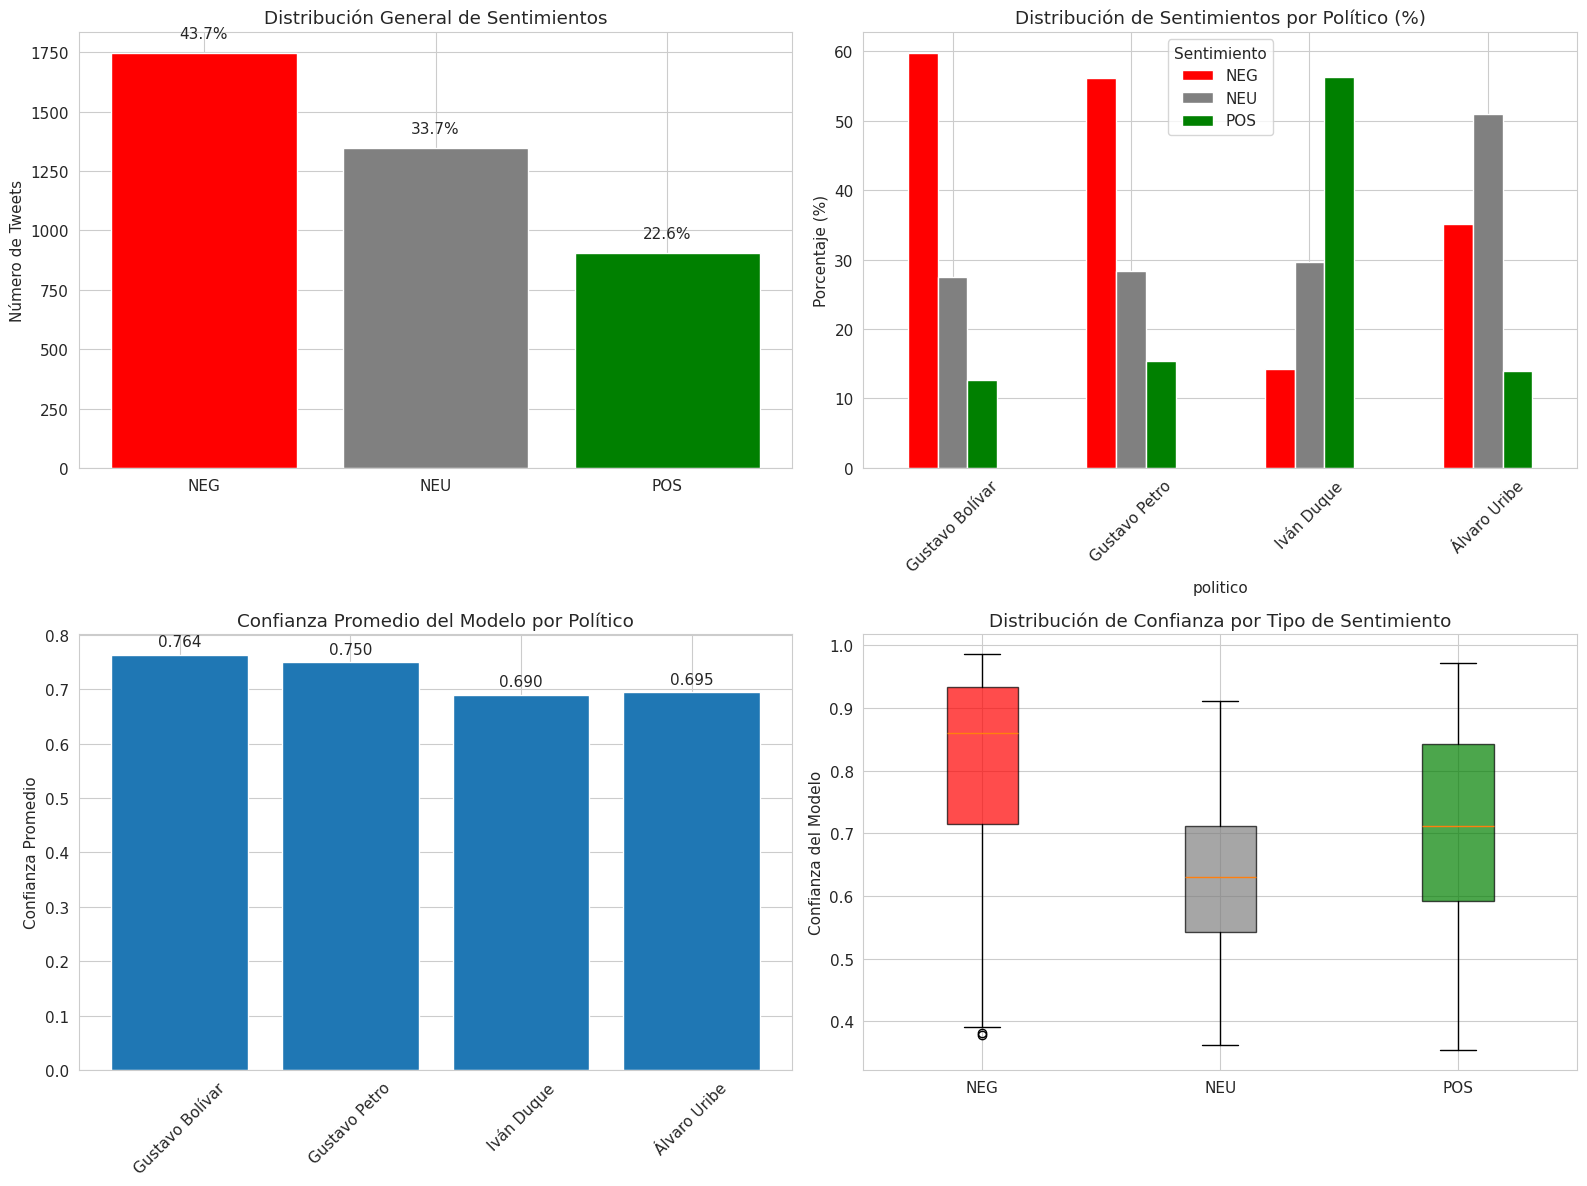

In [ ]:
# Ejecutar visualizaciones
create_sentiment_overview_plots(df)

## 5. Análisis temporal de sentimientos

In [ ]:
def analyze_temporal_sentiment(df):
    """
    Analiza evolución temporal de sentimientos
    """
    # Calcular polaridad por trimestre y político
    temporal_analysis = []

    for politico in df['politico'].unique():
        politico_data = df[df['politico'] == politico]

        for period in politico_data['año_trimestre'].unique():
            period_data = politico_data[politico_data['año_trimestre'] == period]

            if len(period_data) > 0:
                pos_count = (period_data['sentiment_label'] == 'POS').sum()
                neg_count = (period_data['sentiment_label'] == 'NEG').sum()
                neu_count = (period_data['sentiment_label'] == 'NEU').sum()
                total = len(period_data)

                # Calcular polaridad: (positivos - negativos) / total
                polaridad = (pos_count - neg_count) / total if total > 0 else 0

                temporal_analysis.append({
                    'politico': politico,
                    'periodo': period,
                    'positivos': pos_count,
                    'negativos': neg_count,
                    'neutros': neu_count,
                    'total': total,
                    'polaridad': polaridad,
                    'pos_pct': (pos_count / total) * 100,
                    'neg_pct': (neg_count / total) * 100,
                    'neu_pct': (neu_count / total) * 100
                })

    return pd.DataFrame(temporal_analysis)

def visualize_temporal_sentiment(temporal_df):
    """
    Visualiza evolución temporal de sentimientos
    """
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))

    # 1. Evolución de polaridad
    pivot_polaridad = temporal_df.pivot(index='periodo', columns='politico', values='polaridad')

    for politico in pivot_polaridad.columns:
        axes[0].plot(pivot_polaridad.index, pivot_polaridad[politico],
                    marker='o', linewidth=2, label=politico)

    axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
    axes[0].set_title('Evolución de Polaridad Emocional por Trimestre', fontsize=16, fontweight='bold')
    axes[0].set_ylabel('Polaridad (Positivos-Negativos)/Total')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].legend(title='Político', bbox_to_anchor=(1.05, 1))
    axes[0].grid(True, alpha=0.3)

    # 2. Heatmap de sentimientos positivos
    pivot_positivos = temporal_df.pivot(index='politico', columns='periodo', values='pos_pct')

    sns.heatmap(pivot_positivos, annot=True, fmt='.1f', cmap='RdYlGn',
                ax=axes[1], cbar_kws={'label': '% Tweets Positivos'})
    axes[1].set_title('Porcentaje de Tweets Positivos por Político y Período', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Período')
    axes[1].set_ylabel('Político')

    plt.tight_layout()
    plt.show()

    return pivot_polaridad

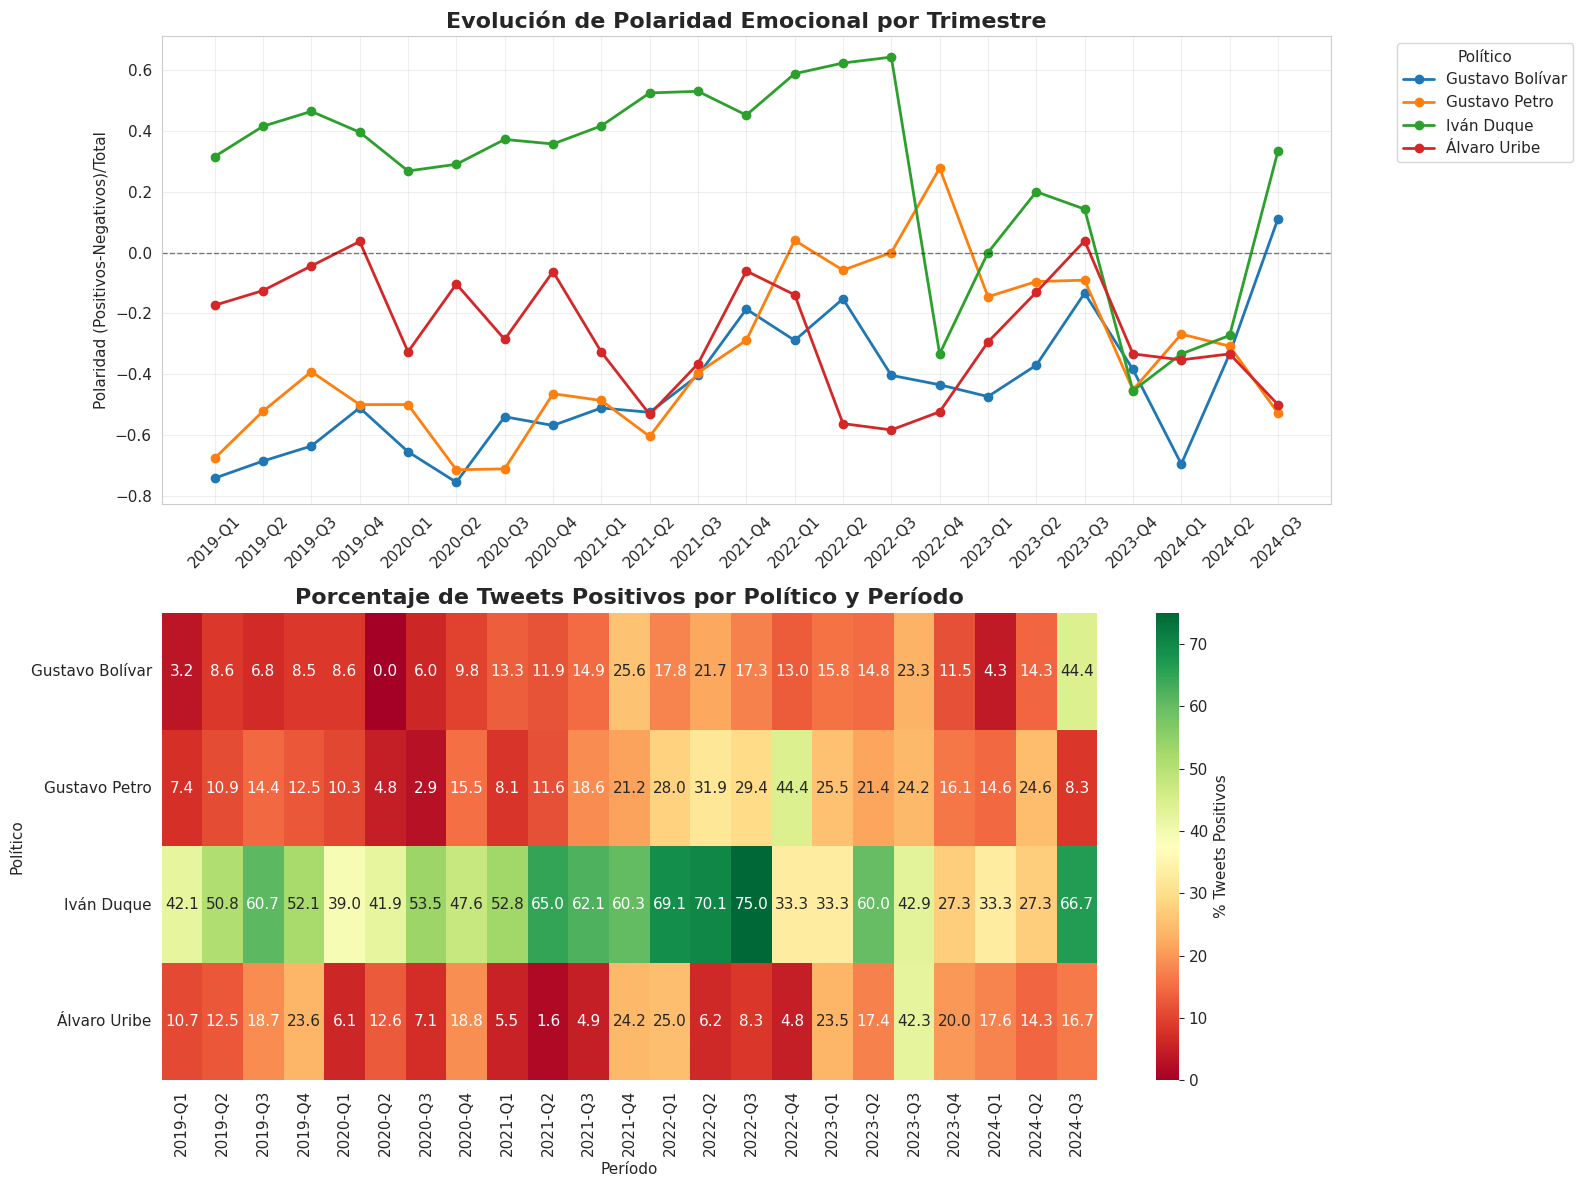


Estadísticas de polaridad por político:

Gustavo Petro:
  Polaridad promedio: -0.343
  Desviación estándar: 0.263
  Máximo: +0.278
  Mínimo: -0.714

Álvaro Uribe:
  Polaridad promedio: -0.265
  Desviación estándar: 0.193
  Máximo: +0.038
  Mínimo: -0.583

Iván Duque:
  Polaridad promedio: +0.258
  Desviación estándar: 0.323
  Máximo: +0.643
  Mínimo: -0.455

Gustavo Bolívar:
  Polaridad promedio: -0.447
  Desviación estándar: 0.217
  Máximo: +0.111
  Mínimo: -0.756


In [ ]:
# Realizar análisis temporal
temporal_sentiment_df = analyze_temporal_sentiment(df)
polaridad_pivot = visualize_temporal_sentiment(temporal_sentiment_df)

# Mostrar estadísticas temporales
print("\nEstadísticas de polaridad por político:")
print("="*50)
for politico in df['politico'].unique():
    pol_data = temporal_sentiment_df[temporal_sentiment_df['politico'] == politico]
    if len(pol_data) > 0:
        avg_polaridad = pol_data['polaridad'].mean()
        std_polaridad = pol_data['polaridad'].std()
        max_polaridad = pol_data['polaridad'].max()
        min_polaridad = pol_data['polaridad'].min()

        print(f"\n{politico}:")
        print(f"  Polaridad promedio: {avg_polaridad:+.3f}")
        print(f"  Desviación estándar: {std_polaridad:.3f}")
        print(f"  Máximo: {max_polaridad:+.3f}")
        print(f"  Mínimo: {min_polaridad:+.3f}")

## 6. Análisis comparativo entre políticos

In [ ]:
def create_politician_sentiment_profiles(df):
    """
    Crea perfiles detallados de sentimiento por político
    """
    profiles = {}

    for politico in df['politico'].unique():
        pol_data = df[df['politico'] == politico]

        # Calcular métricas básicas
        pos_pct = (pol_data['sentiment_label'] == 'POS').mean() * 100
        neg_pct = (pol_data['sentiment_label'] == 'NEG').mean() * 100
        neu_pct = (pol_data['sentiment_label'] == 'NEU').mean() * 100

        # Calcular métricas avanzadas
        polaridad_neta = pos_pct - neg_pct
        confianza_promedio = pol_data['sentiment_confidence'].mean()
        variabilidad_temporal = temporal_sentiment_df[
            temporal_sentiment_df['politico'] == politico]['polaridad'].std()

        # Clasificar perfil emocional
        if polaridad_neta > 10:
            perfil = "Predominantemente Positivo"
        elif polaridad_neta < -10:
            perfil = "Predominantemente Negativo"
        else:
            perfil = "Equilibrado/Neutro"

        profiles[politico] = {
            'positivo_pct': pos_pct,
            'negativo_pct': neg_pct,
            'neutro_pct': neu_pct,
            'polaridad_neta': polaridad_neta,
            'confianza_promedio': confianza_promedio,
            'variabilidad_temporal': variabilidad_temporal,
            'perfil_emocional': perfil,
            'total_tweets': len(pol_data)
        }

    return profiles

def visualize_politician_profiles(profiles):
    """
    Visualiza perfiles comparativos de políticos
    """
    # Crear DataFrame para visualización
    profile_df = pd.DataFrame(profiles).T

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Polaridad neta
    colors = ['green' if x > 0 else 'red' if x < 0 else 'gray' for x in profile_df['polaridad_neta']]
    bars = axes[0, 0].bar(profile_df.index, profile_df['polaridad_neta'], color=colors, alpha=0.7)
    axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
    axes[0, 0].set_title('Polaridad Neta por Político')
    axes[0, 0].set_ylabel('Polaridad Neta (%)')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Añadir valores
    for bar, val in zip(bars, profile_df['polaridad_neta']):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2,
                       bar.get_height() + (1 if val > 0 else -2),
                       f'{val:+.1f}%', ha='center', va='bottom' if val > 0 else 'top')

    # 2. Confianza del modelo
    bars = axes[0, 1].bar(profile_df.index, profile_df['confianza_promedio'])
    axes[0, 1].set_title('Confianza Promedio del Modelo')
    axes[0, 1].set_ylabel('Confianza')
    axes[0, 1].tick_params(axis='x', rotation=45)

    for bar, val in zip(bars, profile_df['confianza_promedio']):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{val:.3f}', ha='center', va='bottom')

    # 3. Variabilidad temporal
    bars = axes[1, 0].bar(profile_df.index, profile_df['variabilidad_temporal'])
    axes[1, 0].set_title('Variabilidad Temporal de Sentimientos')
    axes[1, 0].set_ylabel('Desviación Estándar de Polaridad')
    axes[1, 0].tick_params(axis='x', rotation=45)

    for bar, val in zip(bars, profile_df['variabilidad_temporal']):
        if not pd.isna(val):
            axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                           f'{val:.3f}', ha='center', va='bottom')

    # 4. Distribución de sentimientos (stacked bar)
    bottom_neg = profile_df['negativo_pct']
    bottom_neu = bottom_neg + profile_df['neutro_pct']

    axes[1, 1].bar(profile_df.index, profile_df['negativo_pct'],
                  label='Negativo', color='red', alpha=0.7)
    axes[1, 1].bar(profile_df.index, profile_df['neutro_pct'],
                  bottom=profile_df['negativo_pct'], label='Neutro', color='gray', alpha=0.7)
    axes[1, 1].bar(profile_df.index, profile_df['positivo_pct'],
                  bottom=bottom_neu, label='Positivo', color='green', alpha=0.7)

    axes[1, 1].set_title('Distribución de Sentimientos por Político')
    axes[1, 1].set_ylabel('Porcentaje (%)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

    return profile_df

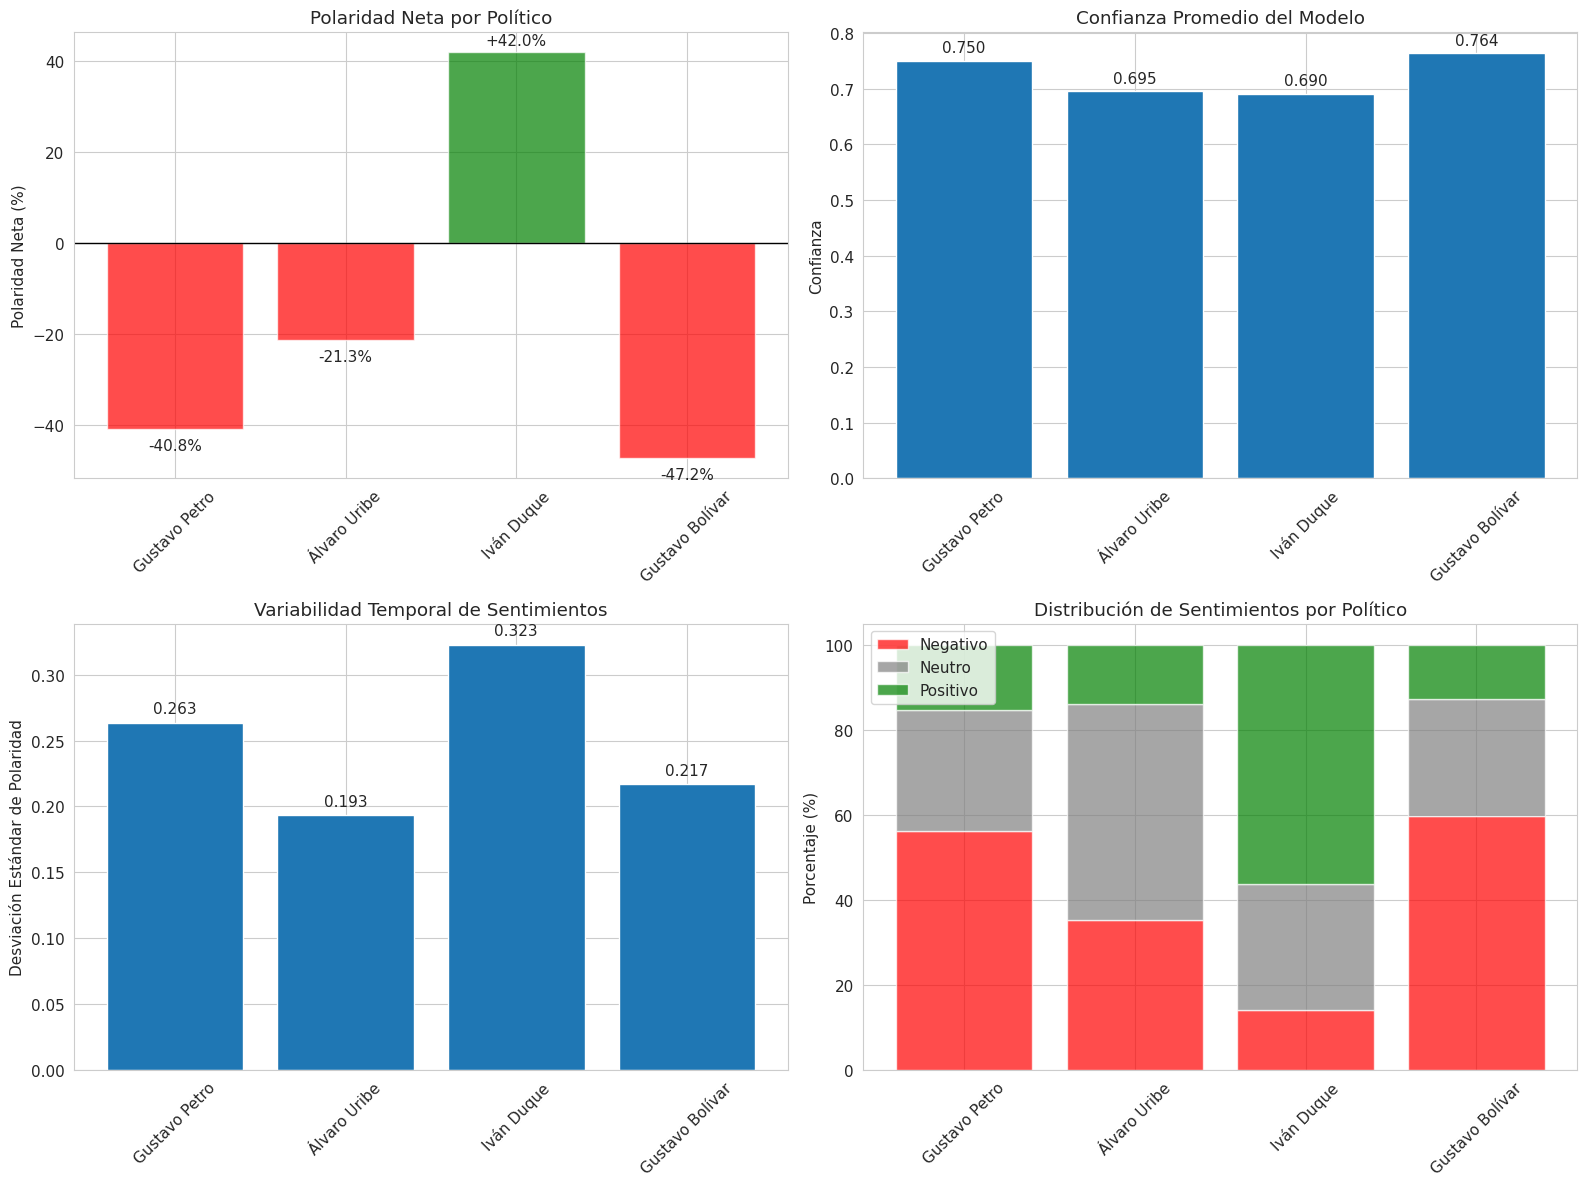


PERFILES EMOCIONALES DE POLÍTICOS

GUSTAVO PETRO:
  Perfil emocional: Predominantemente Negativo
  Polaridad neta: -40.8 puntos
  Tweets positivos: 15.4%
  Tweets negativos: 56.2%
  Tweets neutros: 28.4%
  Confianza del modelo: 0.750
  Variabilidad temporal: 0.263

ÁLVARO URIBE:
  Perfil emocional: Predominantemente Negativo
  Polaridad neta: -21.3 puntos
  Tweets positivos: 13.9%
  Tweets negativos: 35.2%
  Tweets neutros: 50.9%
  Confianza del modelo: 0.695
  Variabilidad temporal: 0.193

IVÁN DUQUE:
  Perfil emocional: Predominantemente Positivo
  Polaridad neta: +42.0 puntos
  Tweets positivos: 56.2%
  Tweets negativos: 14.2%
  Tweets neutros: 29.6%
  Confianza del modelo: 0.690
  Variabilidad temporal: 0.323

GUSTAVO BOLÍVAR:
  Perfil emocional: Predominantemente Negativo
  Polaridad neta: -47.2 puntos
  Tweets positivos: 12.6%
  Tweets negativos: 59.8%
  Tweets neutros: 27.6%
  Confianza del modelo: 0.764
  Variabilidad temporal: 0.217


In [ ]:
# Crear y visualizar perfiles
politician_profiles = create_politician_sentiment_profiles(df)
profile_comparison = visualize_politician_profiles(politician_profiles)

# Mostrar resumen textual
print("\nPERFILES EMOCIONALES DE POLÍTICOS")
print("="*50)

for politico, profile in politician_profiles.items():
    print(f"\n{politico.upper()}:")
    print(f"  Perfil emocional: {profile['perfil_emocional']}")
    print(f"  Polaridad neta: {profile['polaridad_neta']:+.1f} puntos")
    print(f"  Tweets positivos: {profile['positivo_pct']:.1f}%")
    print(f"  Tweets negativos: {profile['negativo_pct']:.1f}%")
    print(f"  Tweets neutros: {profile['neutro_pct']:.1f}%")
    print(f"  Confianza del modelo: {profile['confianza_promedio']:.3f}")
    if not pd.isna(profile['variabilidad_temporal']):
        print(f"  Variabilidad temporal: {profile['variabilidad_temporal']:.3f}")

## 7. Comparación con modelos transformer


In [ ]:
# Cargar modelo transformer alternativo para comparación
print("Cargando modelo transformer de Hugging Face para comparación...")

try:
    # Modelo RoBERTa multilingüe para sentimientos
    transformer_analyzer = pipeline(
        "sentiment-analysis",
        model="cardiffnlp/twitter-roberta-base-sentiment-latest",
        return_all_scores=True
    )
    model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
    print(f"Modelo cargado: {model_name}")
except:
    # Modelo alternativo
    transformer_analyzer = pipeline(
        "sentiment-analysis",
        model="nlptown/bert-base-multilingual-uncased-sentiment",
        return_all_scores=True
    )
    model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
    print(f"Modelo alternativo cargado: {model_name}")

def analyze_sentiment_transformer(text):
    """
    Analiza sentimiento usando transformer de Hugging Face
    """
    if not text or len(text.strip()) < 3:
        return 'NEUTRAL', 0.33

    try:
        # Truncar texto si es muy largo
        text = text[:512]
        result = transformer_analyzer(text)

        # Obtener la predicción con mayor confianza
        best_prediction = max(result[0], key=lambda x: x['score'])
        label = best_prediction['label']
        confidence = best_prediction['score']

        # Mapear etiquetas a formato estándar
        if label in ['POSITIVE', 'POS', '5 stars', '4 stars', 'LABEL_2']:
            return 'POS', confidence
        elif label in ['NEGATIVE', 'NEG', '1 star', '2 stars', 'LABEL_0']:
            return 'NEG', confidence
        else:
            return 'NEU', confidence

    except Exception as e:
        print(f"Error en transformer: {e}")
        return 'NEU', 0.33

Cargando modelo transformer de Hugging Face para comparación...


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Modelo cargado: cardiffnlp/twitter-roberta-base-sentiment-latest


In [ ]:
# Analizar una muestra para comparación
sample_size = min(500, len(df))
sample_df = df.sample(n=sample_size, random_state=42).copy()

print(f"\nAnalizando muestra de {sample_size} tweets con transformer...")

transformer_results = []
for i, text in enumerate(sample_df['texto_sentiment']):
    result = analyze_sentiment_transformer(text)
    transformer_results.append(result)

    if (i + 1) % 100 == 0:
        print(f"  Procesados: {i+1}/{sample_size} tweets")

sample_df['sentiment_transformer'] = [result[0] for result in transformer_results]
sample_df['transformer_confidence'] = [result[1] for result in transformer_results]

print("Análisis con transformer completado")


Analizando muestra de 500 tweets con transformer...
  Procesados: 100/500 tweets
  Procesados: 200/500 tweets
  Procesados: 300/500 tweets
  Procesados: 400/500 tweets
  Procesados: 500/500 tweets
Análisis con transformer completado


### Ejercicio para estudiantes:
**Compara los resultados de ambos modelos:**

In [ ]:
# TU TURNO: Analiza las diferencias entre pysentimiento y transformer

def compare_sentiment_models(sample_df):
    """Compara pysentimiento vs transformer"""

    # 1. Calcular concordancia
    agreement = (sample_df['sentiment_label'] == sample_df['sentiment_transformer']).mean()
    print(f"Concordancia entre modelos: {agreement:.3f} ({agreement*100:.1f}%)")

    # 2. Matriz de confusión
    from sklearn.metrics import confusion_matrix, classification_report

    # Filtrar solo etiquetas comunes
    common_labels = ['POS', 'NEG', 'NEU']
    mask = (sample_df['sentiment_label'].isin(common_labels) &
            sample_df['sentiment_transformer'].isin(common_labels))
    filtered_df = sample_df[mask]

    if len(filtered_df) > 0:
        cm = confusion_matrix(filtered_df['sentiment_label'],
                            filtered_df['sentiment_transformer'],
                            labels=common_labels)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=common_labels, yticklabels=common_labels)
        plt.title('Matriz de Confusión: pysentimiento vs Transformer')
        plt.ylabel('pysentimiento')
        plt.xlabel('Transformer')
        plt.show()

        # Reporte de clasificación
        print("\nReporte de clasificación (transformer vs pysentimiento):")
        print(classification_report(filtered_df['sentiment_label'],
                                  filtered_df['sentiment_transformer']))

    # 3. Comparar confianzas
    print(f"\nConfianza promedio:")
    print(f"  pysentimiento: {sample_df['sentiment_confidence'].mean():.3f}")
    print(f"  Transformer: {sample_df['transformer_confidence'].mean():.3f}")

    # 4. Analizar discrepancias
    discrepancias = sample_df[sample_df['sentiment_label'] != sample_df['sentiment_transformer']]
    print(f"\nTweets con diferentes predicciones: {len(discrepancias)} ({len(discrepancias)/len(sample_df)*100:.1f}%)")

    if len(discrepancias) > 0:
        print(f"\nEjemplos de discrepancias:")
        for i, row in discrepancias.head(3).iterrows():
            print(f"\nTweet: {row['texto_sentiment'][:300]}...")
            print(f"pysentimiento: {row['sentiment_label']} (conf: {row['sentiment_confidence']:.3f})")
            print(f"Transformer: {row['sentiment_transformer']} (conf: {row['transformer_confidence']:.3f})")
            print("-" * 80)

Concordancia entre modelos: 0.358 (35.8%)


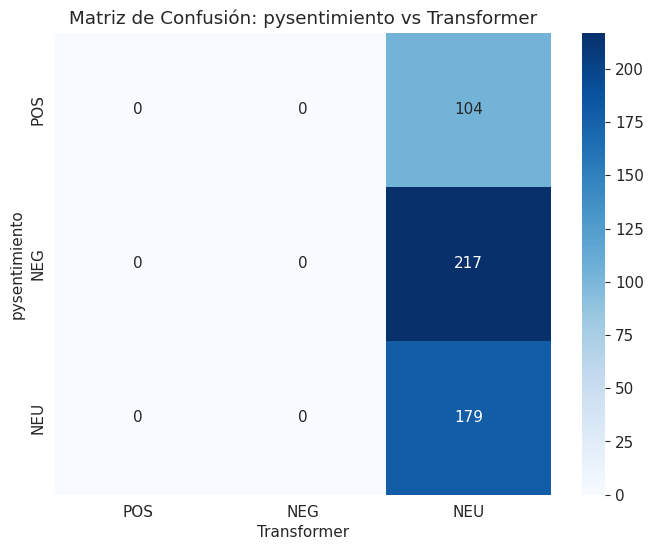


Reporte de clasificación (transformer vs pysentimiento):
              precision    recall  f1-score   support

         NEG       0.00      0.00      0.00       217
         NEU       0.36      1.00      0.53       179
         POS       0.00      0.00      0.00       104

    accuracy                           0.36       500
   macro avg       0.12      0.33      0.18       500
weighted avg       0.13      0.36      0.19       500


Confianza promedio:
  pysentimiento: 0.720
  Transformer: 0.820

Tweets con diferentes predicciones: 321 (64.2%)

Ejemplos de discrepancias:

Tweet: La movilización de Bogotá, además de apoyar la reforma a leyes que vulneraron los derechos de los colombianos: la ley 100 en salud y pensiones, la ley 50 en estabilidad laboral y la ley 30 de desfinanciamiento de la educación superior, debe detener licitaciones de transmilenio...
pysentimiento: NEG (conf: 0.704)
Transformer: NEU (conf: 0.823)
------------------------------------------------------------------

In [ ]:
# Ejecutar comparación
compare_sentiment_models(sample_df)

In [ ]:
print("\nCOMPLETA TU ANÁLISIS:")
print("1. ¿Qué modelo consideras más confiable para tweets políticos en español?")
print("   Tu respuesta: ________________")
print("\n2. ¿Qué ventajas observas en cada modelo?")
print("   pysentimiento: ________________")
print("   Transformer: ________________")
print("\n3. ¿Para qué tipo de análisis usarías cada modelo?")
print("   Tu respuesta: ________________")

## 8. Análisis de eventos y cambios temporales

In [ ]:
def identify_sentiment_events(temporal_df, threshold=0.15):
    """
    Identifica eventos significativos en cambios de sentimiento
    """
    print("DETECCIÓN DE EVENTOS EN SENTIMIENTOS")
    print("="*50)

    events_detected = []

    for politico in temporal_df['politico'].unique():
        pol_data = temporal_df[temporal_df['politico'] == politico].sort_values('periodo')

        if len(pol_data) > 1:
            # Calcular cambios en polaridad
            pol_data = pol_data.copy()
            pol_data['cambio_polaridad'] = pol_data['polaridad'].diff()

            # Identificar cambios significativos
            cambios_significativos = pol_data[abs(pol_data['cambio_polaridad']) > threshold]

            print(f"\n{politico}:")
            print(f"  Polaridad promedio: {pol_data['polaridad'].mean():+.3f}")
            print(f"  Volatilidad (std): {pol_data['polaridad'].std():.3f}")

            if len(cambios_significativos) > 0:
                print(f"  Eventos detectados:")
                for _, row in cambios_significativos.iterrows():
                    direccion = "📈 Mejora" if row['cambio_polaridad'] > 0 else "📉 Deterioro"
                    print(f"    {row['periodo']}: {direccion} ({row['cambio_polaridad']:+.3f})")

                    events_detected.append({
                        'politico': politico,
                        'periodo': row['periodo'],
                        'cambio': row['cambio_polaridad'],
                        'polaridad_nueva': row['polaridad'],
                        'tipo': 'mejora' if row['cambio_polaridad'] > 0 else 'deterioro'
                    })
            else:
                print(f"  Sin cambios significativos detectados")

    return pd.DataFrame(events_detected)

DETECCIÓN DE EVENTOS EN SENTIMIENTOS

Gustavo Petro:
  Polaridad promedio: -0.343
  Volatilidad (std): 0.263
  Eventos detectados:
    2019-Q2: 📈 Mejora (+0.155)
    2019-Q3: 📈 Mejora (+0.130)
    2020-Q2: 📉 Deterioro (-0.214)
    2020-Q4: 📈 Mejora (+0.247)
    2021-Q3: 📈 Mejora (+0.209)
    2022-Q1: 📈 Mejora (+0.328)
    2022-Q4: 📈 Mejora (+0.278)
    2023-Q1: 📉 Deterioro (-0.423)
    2023-Q4: 📉 Deterioro (-0.361)
    2024-Q1: 📈 Mejora (+0.183)
    2024-Q3: 📉 Deterioro (-0.220)

Álvaro Uribe:
  Polaridad promedio: -0.265
  Volatilidad (std): 0.193
  Eventos detectados:
    2020-Q1: 📉 Deterioro (-0.363)
    2020-Q2: 📈 Mejora (+0.223)
    2020-Q3: 📉 Deterioro (-0.182)
    2020-Q4: 📈 Mejora (+0.223)
    2021-Q1: 📉 Deterioro (-0.265)
    2021-Q2: 📉 Deterioro (-0.205)
    2021-Q3: 📈 Mejora (+0.166)
    2021-Q4: 📈 Mejora (+0.305)
    2022-Q2: 📉 Deterioro (-0.424)
    2023-Q1: 📈 Mejora (+0.230)
    2023-Q2: 📈 Mejora (+0.164)
    2023-Q3: 📈 Mejora (+0.169)
    2023-Q4: 📉 Deterioro (-0.372)
  

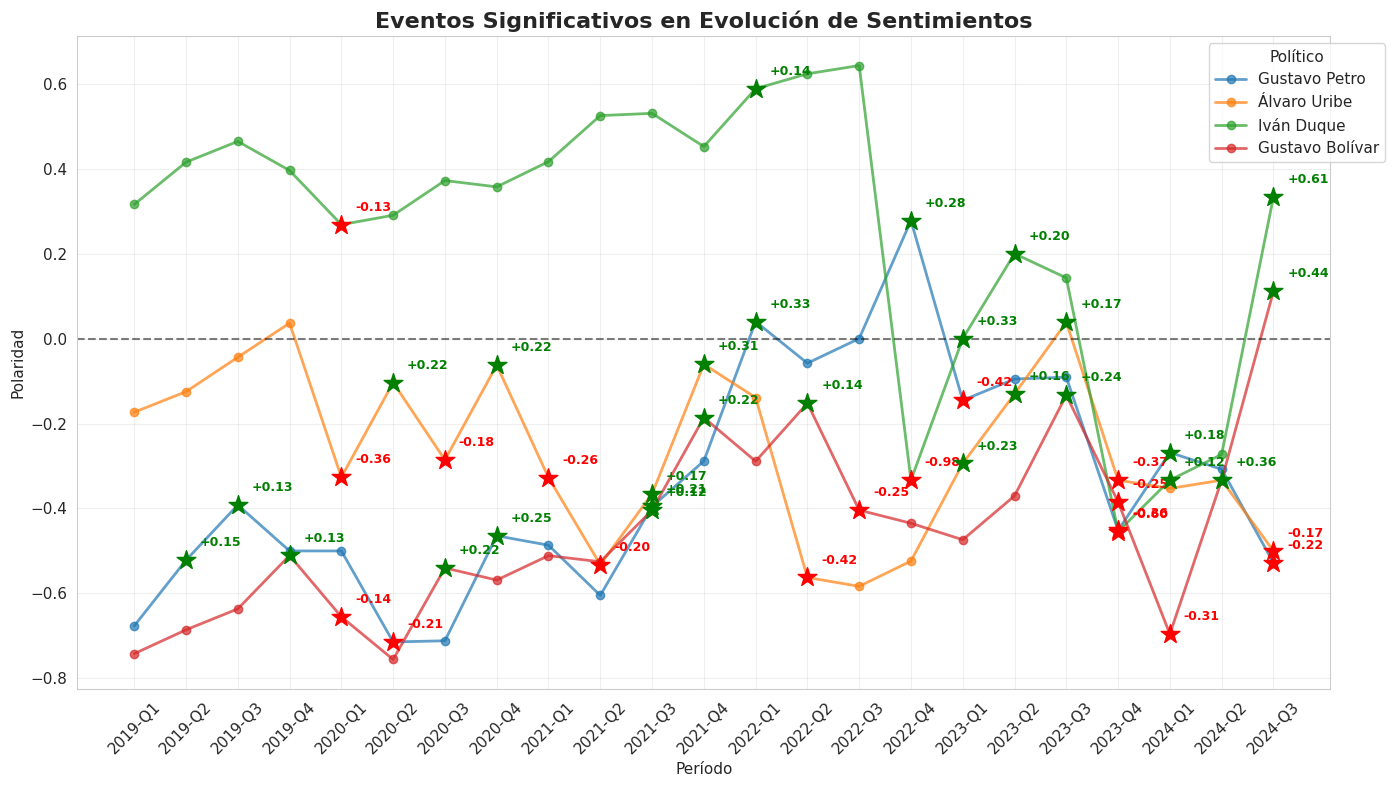

In [ ]:
# Detectar eventos
events_df = identify_sentiment_events(temporal_sentiment_df, threshold=0.12)

# Visualizar eventos detectados
if len(events_df) > 0:
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot líneas de polaridad
    for politico in temporal_sentiment_df['politico'].unique():
        pol_data = temporal_sentiment_df[temporal_sentiment_df['politico'] == politico].sort_values('periodo')
        ax.plot(pol_data['periodo'], pol_data['polaridad'],
               marker='o', linewidth=2, label=politico, alpha=0.7)

    # Marcar eventos
    for _, event in events_df.iterrows():
        color = 'green' if event['tipo'] == 'mejora' else 'red'
        ax.scatter(event['periodo'], event['polaridad_nueva'],
                  color=color, s=200, marker='*', zorder=5)
        ax.annotate(f"{event['cambio']:+.2f}",
                   (event['periodo'], event['polaridad_nueva']),
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=9, color=color, fontweight='bold')

    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.set_title('Eventos Significativos en Evolución de Sentimientos', fontsize=16, fontweight='bold')
    ax.set_ylabel('Polaridad')
    ax.set_xlabel('Período')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Político', bbox_to_anchor=(1.05, 1))
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No se detectaron eventos significativos con el umbral actual")

### Ejercicio:
**Conecta cambios en sentimientos con eventos políticos:**

In [ ]:
# TU TURNO: Analiza eventos políticos que expliquen los cambios

print("ANÁLISIS DE EVENTOS POLÍTICOS")
print("="*40)

# Diccionario para que los estudiantes completen
eventos_politicos_importantes = {
    # Ejemplo de formato:
    # "2020-Q2": "Inicio de pandemia COVID-19",
    # "2022-Q2": "Elecciones presidenciales primera vuelta",
    # "2022-Q3": "Elecciones presidenciales segunda vuelta",
    # Completa con eventos que identifiques:
}

print("1. Revisa los períodos con cambios significativos detectados")
print("2. Investiga qué eventos políticos ocurrieron en esos trimestres")
print("3. Completa el diccionario eventos_politicos_importantes")

print(f"\nEventos identificados automáticamente:")
if len(events_df) > 0:
    for _, event in events_df.iterrows():
        print(f"  {event['politico']} en {event['periodo']}: {event['tipo']} ({event['cambio']:+.3f})")

print(f"\n4. Reflexiones:")
print("¿Qué eventos políticos podrían explicar los cambios observados?")
print("Tu respuesta: ________________")

print("\n¿Observas patrones comunes entre políticos en ciertos períodos?")
print("Tu respuesta: ________________")

print("\n¿Qué político muestra mayor volatilidad emocional?")
print("Tu respuesta: ________________")

ANÁLISIS DE EVENTOS POLÍTICOS
1. Revisa los períodos con cambios significativos detectados
2. Investiga qué eventos políticos ocurrieron en esos trimestres
3. Completa el diccionario eventos_politicos_importantes

Eventos identificados automáticamente:
  Gustavo Petro en 2019-Q2: mejora (+0.155)
  Gustavo Petro en 2019-Q3: mejora (+0.130)
  Gustavo Petro en 2020-Q2: deterioro (-0.214)
  Gustavo Petro en 2020-Q4: mejora (+0.247)
  Gustavo Petro en 2021-Q3: mejora (+0.209)
  Gustavo Petro en 2022-Q1: mejora (+0.328)
  Gustavo Petro en 2022-Q4: mejora (+0.278)
  Gustavo Petro en 2023-Q1: deterioro (-0.423)
  Gustavo Petro en 2023-Q4: deterioro (-0.361)
  Gustavo Petro en 2024-Q1: mejora (+0.183)
  Gustavo Petro en 2024-Q3: deterioro (-0.220)
  Álvaro Uribe en 2020-Q1: deterioro (-0.363)
  Álvaro Uribe en 2020-Q2: mejora (+0.223)
  Álvaro Uribe en 2020-Q3: deterioro (-0.182)
  Álvaro Uribe en 2020-Q4: mejora (+0.223)
  Álvaro Uribe en 2021-Q1: deterioro (-0.265)
  Álvaro Uribe en 2021-Q2: 


## 9. Análisis avanzado: palabras asociadas a sentimientos

In [ ]:
def analyze_sentiment_vocabulary(df):
    """
    Analiza vocabulario asociado a diferentes sentimientos
    """
    print("VOCABULARIO ASOCIADO A SENTIMIENTOS")
    print("="*45)

    # Cargar modelo spaCy para análisis de vocabulario
    try:
        import spacy
        nlp = spacy.load('es_core_news_sm')
    except:
        print("Instalando y cargando spaCy...")
        import subprocess
        subprocess.run(["python", "-m", "spacy", "download", "es_core_news_sm"], check=True)
        import spacy
        nlp = spacy.load('es_core_news_sm')

    sentiment_vocab = {}

    for sentiment in ['POS', 'NEG', 'NEU']:
        sentiment_tweets = df[df['sentiment_label'] == sentiment]['texto_sentiment']

        # Extraer palabras relevantes
        all_words = []
        for text in sentiment_tweets.head(1000):  # Muestra para eficiencia
            if len(text) > 10:
                doc = nlp(text)
                words = [token.lemma_.lower() for token in doc
                        if not token.is_stop and not token.is_punct
                        and token.is_alpha and len(token.text) > 3]
                all_words.extend(words)

        # Contar frecuencias
        word_freq = Counter(all_words).most_common(20)
        sentiment_vocab[sentiment] = word_freq

        print(f"\n{sentiment} - Palabras más frecuentes:")
        for word, freq in word_freq[:10]:
            print(f"  {word}: {freq}")

    return sentiment_vocab

def visualize_sentiment_vocabulary(sentiment_vocab):
    """
    Visualiza vocabulario por sentimiento
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    sentiments = ['NEG', 'NEU', 'POS']
    colors = ['red', 'gray', 'green']

    for i, (sentiment, color) in enumerate(zip(sentiments, colors)):
        if sentiment in sentiment_vocab:
            words = [item[0] for item in sentiment_vocab[sentiment][:12]]
            frequencies = [item[1] for item in sentiment_vocab[sentiment][:12]]

            bars = axes[i].barh(range(len(words)), frequencies, color=color, alpha=0.7)
            axes[i].set_yticks(range(len(words)))
            axes[i].set_yticklabels(words)
            axes[i].set_xlabel('Frecuencia')
            axes[i].set_title(f'Vocabulario {sentiment}')
            axes[i].invert_yaxis()

            # Añadir valores
            for j, (bar, freq) in enumerate(zip(bars, frequencies)):
                axes[i].text(freq + 1, j, str(freq), va='center')

    plt.tight_layout()
    plt.show()

VOCABULARIO ASOCIADO A SENTIMIENTOS
Instalando y cargando spaCy...

POS - Palabras más frecuentes:
  colombia: 209
  país: 192
  colombiano: 82
  gobierno: 81
  gracias: 74
  millón: 65
  bogotá: 62
  social: 62
  año: 59
  seguir: 57

NEG - Palabras más frecuentes:
  colombia: 178
  duque: 120
  gobierno: 101
  país: 85
  bogotá: 83
  social: 69
  salud: 63
  colombiano: 62
  público: 60
  pasar: 53

NEU - Palabras más frecuentes:
  colombia: 145
  gobierno: 84
  bogotá: 69
  país: 64
  millón: 54
  social: 50
  público: 46
  colombiano: 44
  nacional: 41
  salud: 37


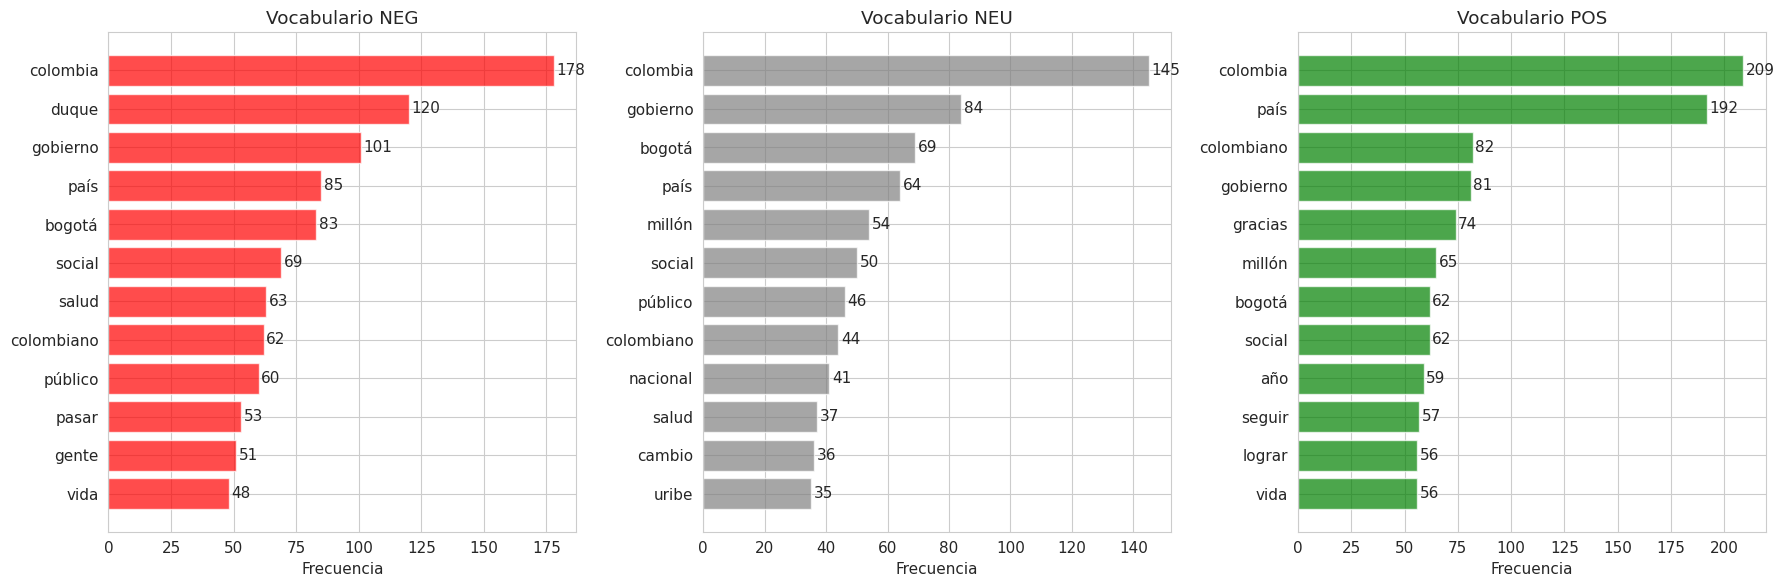

In [ ]:
vocab_by_sentiment = analyze_sentiment_vocabulary(df)
visualize_sentiment_vocabulary(vocab_by_sentiment)

## 10. Dashboard interactivo con Plotly

In [ ]:
def create_interactive_sentiment_dashboard(df, temporal_df):
    """
    Crea dashboard interactivo para explorar sentimientos
    """
    # 1. Gráfico temporal interactivo
    fig_temporal = go.Figure()

    for politico in temporal_df['politico'].unique():
        pol_data = temporal_df[temporal_df['politico'] == politico].sort_values('periodo')

        fig_temporal.add_trace(go.Scatter(
            x=pol_data['periodo'],
            y=pol_data['polaridad'],
            mode='lines+markers',
            name=politico,
            line=dict(width=3),
            marker=dict(size=8),
            hovertemplate='<b>%{fullData.name}</b><br>' +
                         'Período: %{x}<br>' +
                         'Polaridad: %{y:.3f}<br>' +
                         '<extra></extra>'
        ))

    fig_temporal.add_hline(y=0, line_dash="dash", line_color="black", opacity=0.5)
    fig_temporal.update_layout(
        title='Evolución Temporal de Polaridad Emocional (Interactivo)',
        xaxis_title='Período',
        yaxis_title='Polaridad (Positivos-Negativos)/Total',
        hovermode='x unified',
        height=500
    )

    fig_temporal.show()

    # 2. Distribución por político (interactivo)
    fig_dist = go.Figure()

    sentiments = ['NEG', 'NEU', 'POS']
    colors = ['red', 'gray', 'green']

    for sentiment, color in zip(sentiments, colors):
        values = []
        for politico in df['politico'].unique():
            pol_data = df[df['politico'] == politico]
            pct = (pol_data['sentiment_label'] == sentiment).mean() * 100
            values.append(pct)

        fig_dist.add_trace(go.Bar(
            x=df['politico'].unique(),
            y=values,
            name=sentiment,
            marker_color=color,
            opacity=0.8,
            hovertemplate='<b>%{fullData.name}</b><br>' +
                         'Político: %{x}<br>' +
                         'Porcentaje: %{y:.1f}%<br>' +
                         '<extra></extra>'
        ))

    fig_dist.update_layout(
        title='Distribución de Sentimientos por Político (Interactivo)',
        xaxis_title='Político',
        yaxis_title='Porcentaje (%)',
        barmode='stack',
        height=500
    )

    fig_dist.show()

    # 3. Scatter plot: Polaridad vs Confianza
    fig_scatter = go.Figure()

    for politico in df['politico'].unique():
        pol_data = df[df['politico'] == politico]

        # Calcular polaridad promedio y confianza promedio
        pos_pct = (pol_data['sentiment_label'] == 'POS').mean() * 100
        neg_pct = (pol_data['sentiment_label'] == 'NEG').mean() * 100
        polaridad = pos_pct - neg_pct
        confianza = pol_data['sentiment_confidence'].mean()

        fig_scatter.add_trace(go.Scatter(
            x=[confianza],
            y=[polaridad],
            mode='markers+text',
            name=politico,
            marker=dict(size=15, opacity=0.8),
            text=[politico],
            textposition="top center",
            hovertemplate='<b>%{text}</b><br>' +
                         'Confianza: %{x:.3f}<br>' +
                         'Polaridad: %{y:.1f}<br>' +
                         '<extra></extra>'
        ))

    fig_scatter.add_hline(y=0, line_dash="dash", line_color="black", opacity=0.5)
    fig_scatter.update_layout(
        title='Polaridad vs Confianza del Modelo por Político',
        xaxis_title='Confianza Promedio del Modelo',
        yaxis_title='Polaridad Neta (%)',
        showlegend=False,
        height=500
    )

    fig_scatter.show()

In [ ]:
# Crear dashboard interactivo
print("Creando dashboard interactivo...")
create_interactive_sentiment_dashboard(df, temporal_sentiment_df)

Creando dashboard interactivo...


## 11. Análisis estadístico avanzado

In [ ]:
def advanced_statistical_analysis(df, temporal_df):
    """
    Análisis estadístico avanzado de sentimientos
    """
    from scipy import stats

    print("ANÁLISIS ESTADÍSTICO AVANZADO")
    print("="*40)

    # 1. Test de normalidad para polaridades
    print("\n1. TESTS DE NORMALIDAD:")
    for politico in temporal_df['politico'].unique():
        pol_data = temporal_df[temporal_df['politico'] == politico]['polaridad']
        if len(pol_data) > 3:
            statistic, p_value = stats.shapiro(pol_data)
            print(f"  {politico}:")
            print(f"    Shapiro-Wilk: p-value = {p_value:.4f}")
            print(f"    Distribución: {'Normal' if p_value > 0.05 else 'No normal'}")

    # 2. Comparación entre políticos (ANOVA)
    print(f"\n2. COMPARACIÓN ENTRE POLÍTICOS:")

    # Preparar datos para ANOVA
    groups = []
    for politico in df['politico'].unique():
        pol_data = df[df['politico'] == politico]
        # Convertir sentimientos a valores numéricos
        sentiment_values = pol_data['sentiment_label'].map({'NEG': -1, 'NEU': 0, 'POS': 1})
        groups.append(sentiment_values.dropna())

    if len(groups) > 1:
        f_statistic, p_value = stats.f_oneway(*groups)
        print(f"  ANOVA F-statistic: {f_statistic:.4f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  Resultado: {'Diferencias significativas' if p_value < 0.05 else 'Sin diferencias significativas'}")

    # 3. Correlaciones temporales
    print(f"\n3. ANÁLISIS DE CORRELACIONES TEMPORALES:")

    # Crear matriz de correlaciones entre políticos
    pivot_polaridad = temporal_df.pivot(index='periodo', columns='politico', values='polaridad')
    correlations = pivot_polaridad.corr()

    print("  Correlaciones de polaridad entre políticos:")
    for i, pol1 in enumerate(correlations.columns):
        for j, pol2 in enumerate(correlations.columns):
            if i < j:  # Solo mostrar triángulo superior
                corr_val = correlations.loc[pol1, pol2]
                if not pd.isna(corr_val):
                    print(f"    {pol1} - {pol2}: {corr_val:.3f}")

    # Visualizar matriz de correlaciones
    plt.figure(figsize=(8, 6))
    mask = np.triu(np.ones_like(correlations, dtype=bool))
    sns.heatmap(correlations, mask=mask, annot=True, fmt='.3f',
                cmap='RdBu_r', center=0, vmin=-1, vmax=1)
    plt.title('Correlaciones de Polaridad entre Políticos')
    plt.tight_layout()
    plt.show()

    # 4. Tendencias temporales
    print(f"\n4. TENDENCIAS TEMPORALES:")

    for politico in temporal_df['politico'].unique():
        pol_data = temporal_df[temporal_df['politico'] == politico].sort_values('periodo')
        if len(pol_data) > 3:
            # Crear variable numérica para el tiempo
            pol_data['periodo_num'] = range(len(pol_data))

            # Regresión lineal simple
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                pol_data['periodo_num'], pol_data['polaridad'])

            print(f"  {politico}:")
            print(f"    Tendencia: {slope:+.4f} por trimestre")
            print(f"    R²: {r_value**2:.3f}")
            print(f"    Significancia: {'Sí' if p_value < 0.05 else 'No'} (p={p_value:.4f})")

ANÁLISIS ESTADÍSTICO AVANZADO

1. TESTS DE NORMALIDAD:
  Gustavo Petro:
    Shapiro-Wilk: p-value = 0.2868
    Distribución: Normal
  Álvaro Uribe:
    Shapiro-Wilk: p-value = 0.1745
    Distribución: Normal
  Iván Duque:
    Shapiro-Wilk: p-value = 0.0044
    Distribución: No normal
  Gustavo Bolívar:
    Shapiro-Wilk: p-value = 0.3550
    Distribución: Normal

2. COMPARACIÓN ENTRE POLÍTICOS:
  ANOVA F-statistic: 284.1860
  p-value: 0.0000
  Resultado: Diferencias significativas

3. ANÁLISIS DE CORRELACIONES TEMPORALES:
  Correlaciones de polaridad entre políticos:
    Gustavo Bolívar - Gustavo Petro: 0.425
    Gustavo Bolívar - Iván Duque: 0.074
    Gustavo Bolívar - Álvaro Uribe: -0.224
    Gustavo Petro - Iván Duque: -0.183
    Gustavo Petro - Álvaro Uribe: -0.220
    Iván Duque - Álvaro Uribe: 0.084


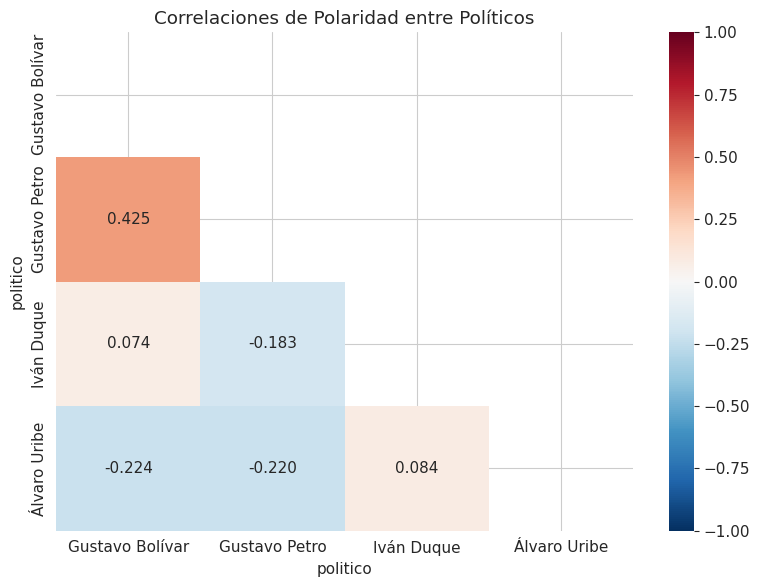


4. TENDENCIAS TEMPORALES:
  Gustavo Petro:
    Tendencia: +0.0204 por trimestre
    R²: 0.276
    Significancia: Sí (p=0.0101)
  Álvaro Uribe:
    Tendencia: -0.0114 por trimestre
    R²: 0.159
    Significancia: No (p=0.0593)
  Iván Duque:
    Tendencia: -0.0255 por trimestre
    R²: 0.287
    Significancia: Sí (p=0.0085)
  Gustavo Bolívar:
    Tendencia: +0.0211 por trimestre
    R²: 0.437
    Significancia: Sí (p=0.0006)


In [ ]:
# Ejecutar análisis estadístico
advanced_statistical_analysis(df, temporal_sentiment_df)

## 12. Exportamos resultados y síntesis

In [ ]:
def export_sentiment_results(df, temporal_df, politician_profiles):
    """
    Exporta resultados del análisis para uso posterior
    """
    print("EXPORTANDO RESULTADOS DEL ANÁLISIS")
    print("="*40)

    # 1. Dataset con sentimientos
    df_export = df[['politico', 'texto', 'fecha', 'año_trimestre',
                   'sentiment_label', 'sentiment_confidence']].copy()
    df_export.to_csv('tweets_con_sentimientos_detallado.csv', index=False)
    print("✓ Dataset con sentimientos: tweets_con_sentimientos_detallado.csv")

    # 2. Resumen temporal
    temporal_df.to_csv('evolucion_temporal_sentimientos.csv', index=False)
    print("✓ Evolución temporal: evolucion_temporal_sentimientos.csv")

    # 3. Perfiles de políticos
    profile_df = pd.DataFrame(politician_profiles).T
    profile_df.to_csv('perfiles_sentimiento_politicos.csv')
    print("✓ Perfiles políticos: perfiles_sentimiento_politicos.csv")

    # 4. Resumen ejecutivo
    with open('resumen_analisis_sentimientos.txt', 'w', encoding='utf-8') as f:
        f.write("RESUMEN EJECUTIVO - ANÁLISIS DE SENTIMIENTOS\n")
        f.write("="*50 + "\n\n")

        f.write(f"DATOS PROCESADOS:\n")
        f.write(f"- Total tweets analizados: {len(df):,}\n")
        f.write(f"- Período: {df['fecha'].min()} - {df['fecha'].max()}\n")
        f.write(f"- Políticos: {', '.join(df['politico'].unique())}\n\n")

        f.write("RESULTADOS PRINCIPALES:\n")
        for politico, profile in politician_profiles.items():
            f.write(f"\n{politico}:\n")
            f.write(f"  - Perfil emocional: {profile['perfil_emocional']}\n")
            f.write(f"  - Polaridad neta: {profile['polaridad_neta']:+.1f} puntos\n")
            f.write(f"  - Confianza del modelo: {profile['confianza_promedio']:.3f}\n")

    print("✓ Resumen ejecutivo: resumen_analisis_sentimientos.txt")

    # 5. Descargar archivos en Colab
    from google.colab import files

    files.download('tweets_con_sentimientos_detallado.csv')
    files.download('evolucion_temporal_sentimientos.csv')
    files.download('perfiles_sentimiento_politicos.csv')
    files.download('resumen_analisis_sentimientos.txt')

    print("\n📁 Todos los archivos han sido descargados")

In [ ]:
# Exportar resultados
export_sentiment_results(df, temporal_sentiment_df, politician_profiles)